Feature Matrix Shape: (800, 10000)
Training Random Forest Model...

10-Fold CV Mean Accuracy: 0.5713

--- Test Set Classification Report ---
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.50      0.72      0.59        40
Frontotemporal Dementia       0.60      0.62      0.61        40
     Lewy Body Dementia       0.70      0.53      0.60        40
    Parkinson's Disease       0.72      0.57      0.64        40
      Vascular Dementia       0.71      0.68      0.69        40

               accuracy                           0.62       200
              macro avg       0.64      0.62      0.63       200
           weighted avg       0.64      0.62      0.63       200



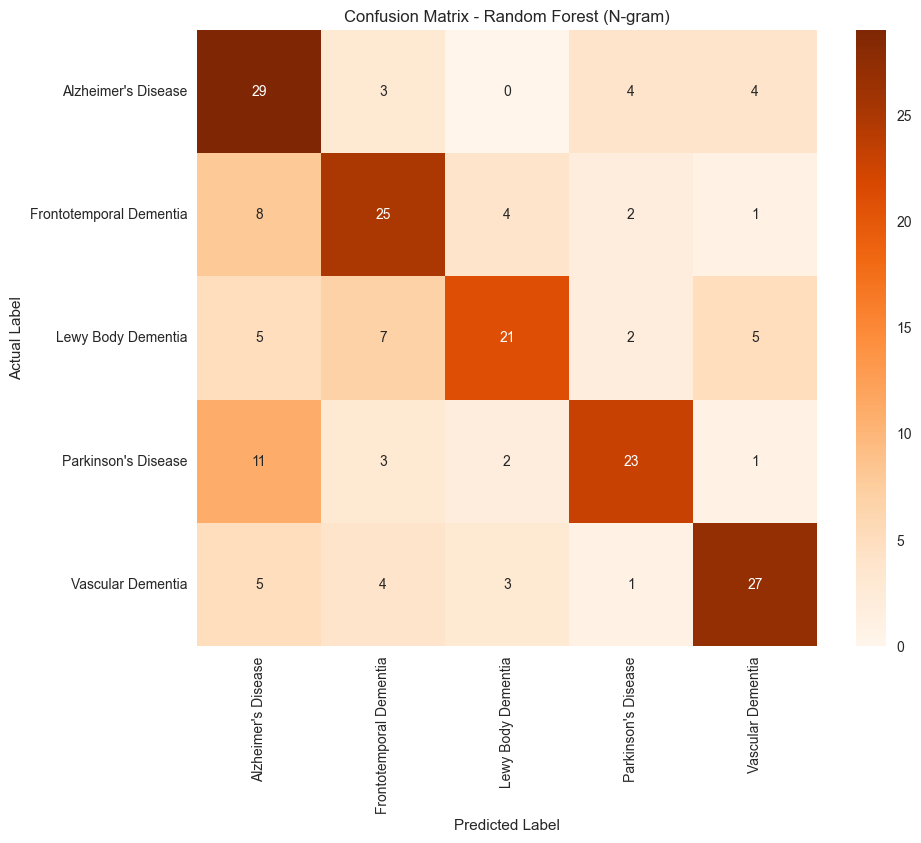

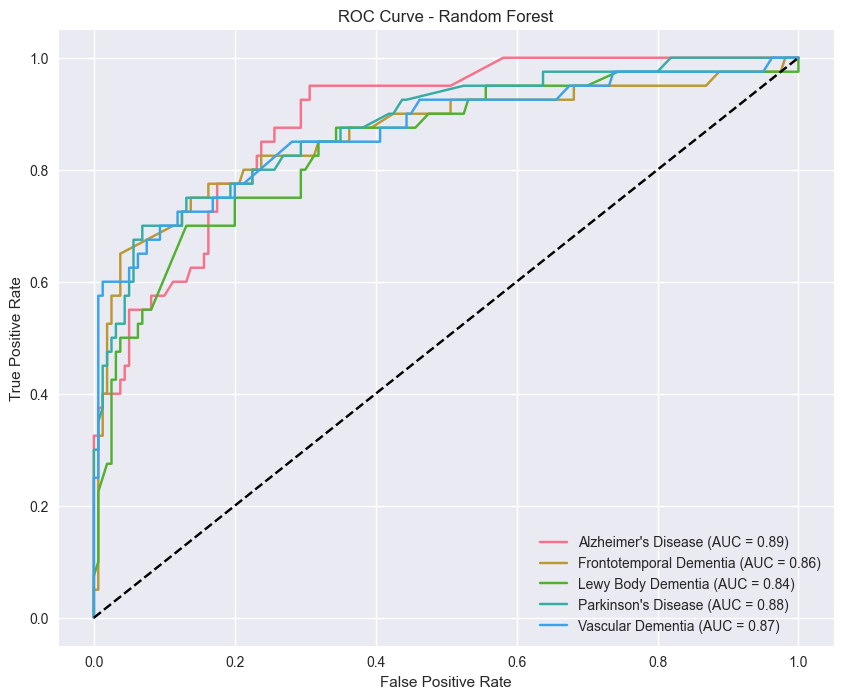

C:\Users\yeyude\AppData\Local\Temp\ipykernel_11236\2101730155.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=[feature_names[i] for i in indices], palette="viridis")


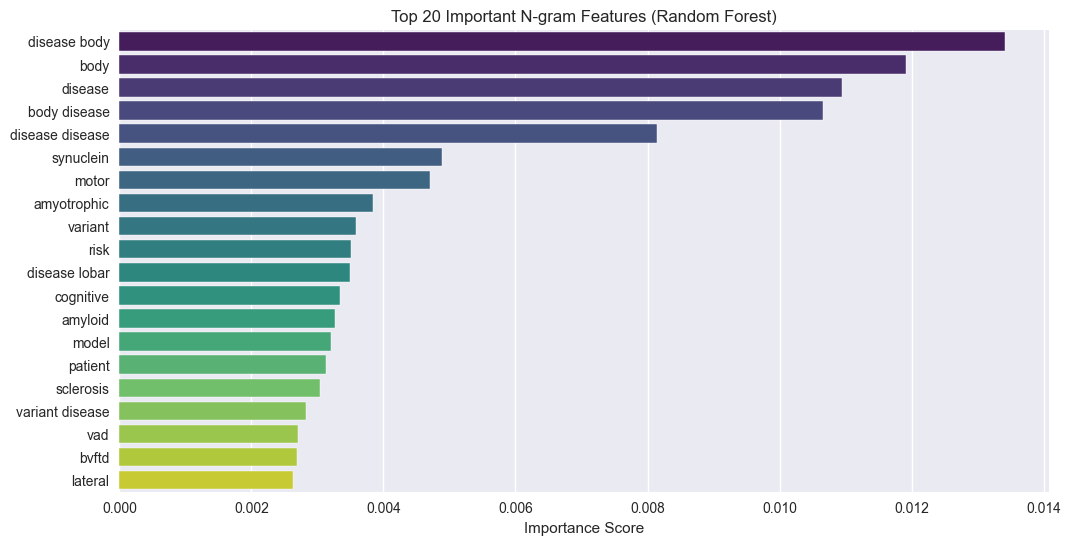


--- Starting SHAP Explainability Analysis ---
Total misclassified samples found: 75

[Analyzing Sample ID: 567]
True Label: Lewy Body Dementia
Predicted Label: Alzheimer's Disease (Model Error!)
Text Snippet: growing body evidence support use cardiac sympathetic innervation imaging risk stratify patient heart failure particular using cardiac metaiodobenzylg...

Initializing SHAP TreeExplainer...
Calculating SHAP Values (Please wait)...
Generating Waterfall Plot for predicted class 'Alzheimer's Disease'...


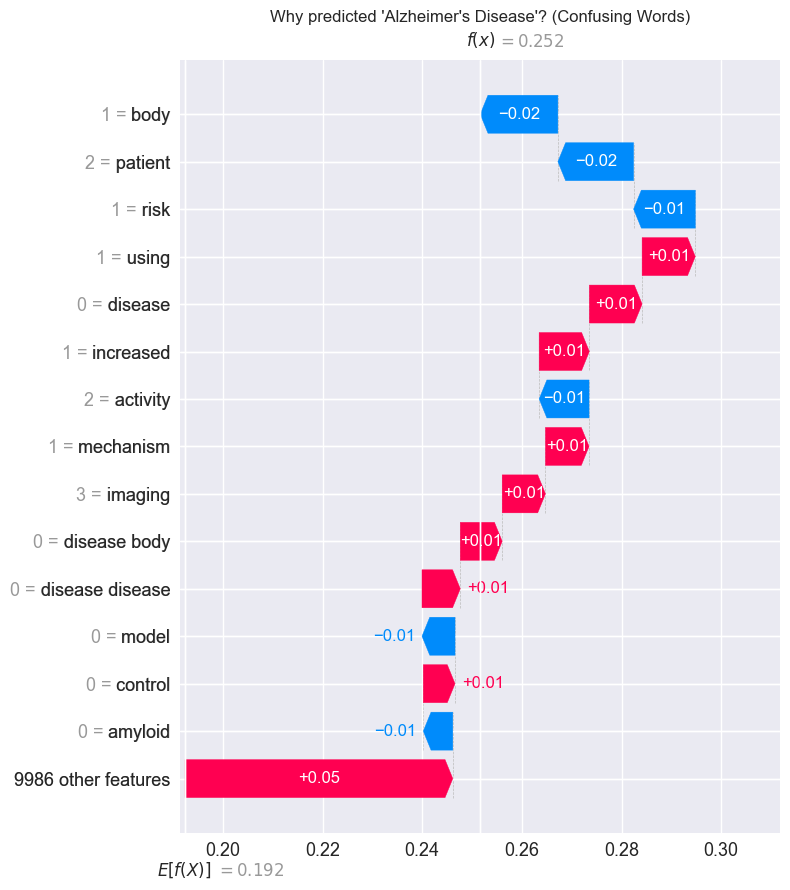


[Chart Interpretation Guide]:
1. Red bars: Words that significantly increased the probability of the WRONG prediction (Confusing Words).
2. Blue bars: Words that tried to push the prediction towards the correct label but failed.
3. E[f(x)]: Base probability, the average probability of predicting this class without seeing any text.
4. f(x): Final prediction score.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap  # Ensure shap is installed: pip install shap

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ==========================================
# 1. Data Preparation
# ==========================================
# Read CSV file
try:
    df = pd.read_csv('../cleaned_data.csv')
except FileNotFoundError:
    df = pd.read_csv('cleaned_data.csv')

# Ensure no empty values in text content
df['Cleaned_Content'] = df['Cleaned_Content'].fillna('')

# Split into training and testing sets (80% Train, 20% Test)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['Cleaned_Content'], df['Label'], test_size=0.2, random_state=42, stratify=df['Label']
)

# ==========================================
# 2. Feature Engineering: N-gram (Unigram + Bigram)
# ==========================================
# Use CountVectorizer to extract 1-gram and 2-gram features
# max_features limited to 10000 most common features to prevent RF from training too slowly
# Note: For SHAP analysis, feature names are important.
vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=10000)

X_train_vec = vectorizer.fit_transform(X_train_raw)
X_test_vec = vectorizer.transform(X_test_raw)

print(f"Feature Matrix Shape: {X_train_vec.shape}")

# ==========================================
# 3. Model Training: Random Forest Classifier
# ==========================================
# n_estimators=100: Number of trees
# n_jobs=-1: Use all CPU cores for acceleration
print("Training Random Forest Model...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# 10-Fold Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_model, X_train_vec, y_train, cv=cv, scoring='accuracy')

print(f"\n10-Fold CV Mean Accuracy: {cv_scores.mean():.4f}")

# Train on the full training set
rf_model.fit(X_train_vec, y_train)

# ==========================================
# 4. Evaluation & Visualization
# ==========================================
y_pred = rf_model.predict(X_test_vec)
y_prob = rf_model.predict_proba(X_test_vec)

print("\n--- Test Set Classification Report ---")
print(classification_report(y_test, y_pred))

# [Chart 1] Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix - Random Forest (N-gram)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# [Chart 2] ROC Curve
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
classes = lb.classes_

plt.figure(figsize=(10, 8))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

# [Chart 3] Feature Importance
# Random Forest can directly output feature importance
feature_names = vectorizer.get_feature_names_out()
importances = rf_model.feature_importances_
# Get top 20 most important features
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=[feature_names[i] for i in indices], palette="viridis")
plt.title("Top 20 Important N-gram Features (Random Forest)")
plt.xlabel("Importance Score")
plt.show()

# ==========================================
# 5. SHAP Error Analysis (Explainability)
# ==========================================
print("\n--- Starting SHAP Explainability Analysis ---")

# Step A: Identify misclassified samples
# Create a temporary DataFrame for easier indexing
test_results = pd.DataFrame({
    'Text': X_test_raw, # Original text
    'True_Label': y_test,
    'Pred_Label': y_pred
})

# Filter rows where True Label != Predicted Label
errors = test_results[test_results['True_Label'] != test_results['Pred_Label']]
print(f"Total misclassified samples found: {len(errors)}")

if len(errors) > 0:
    # Step B: Select a specific error case for analysis
    # Defaulting to the first error sample (iloc[0]), change to iloc[1] to check others
    error_idx = errors.index[0]

    # Get the location index of this sample in the test set matrix (for feature extraction)
    loc_idx = list(X_test_raw.index).index(error_idx)

    sample_text = errors.loc[error_idx, 'Text']
    true_label = errors.loc[error_idx, 'True_Label']
    pred_label = errors.loc[error_idx, 'Pred_Label']

    print(f"\n[Analyzing Sample ID: {error_idx}]")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {pred_label} (Model Error!)")
    print(f"Text Snippet: {sample_text[:150]}...") # Print first 150 characters

    # ---------------------------------------------------------
    # Step C: Initialize SHAP TreeExplainer
    # ---------------------------------------------------------
    print("\nInitializing SHAP TreeExplainer...")
    # TreeExplainer is most efficient for Random Forest.
    # While rf_model can be used directly, passing a small background dataset (as dense array)
    # is recommended to calculate Expected Value and avoid Additivity errors.
    background_data = X_train_vec[:50].toarray()
    explainer = shap.TreeExplainer(rf_model, data=background_data)

    # ---------------------------------------------------------
    # Step D: Calculate SHAP Values
    # ---------------------------------------------------------
    print("Calculating SHAP Values (Please wait)...")

    # Extract feature vector for the target sample (convert to dense array)
    target_sample = X_test_vec[loc_idx].toarray()

    # Calculate SHAP values
    # check_additivity=False prevents errors due to floating point precision issues
    shap_values = explainer.shap_values(target_sample, check_additivity=False)

    # ---------------------------------------------------------
    # Step E: Intelligent Visualization (Waterfall Plot)
    # ---------------------------------------------------------
    print(f"Generating Waterfall Plot for predicted class '{pred_label}'...")

    # 1. Get the numeric index of the predicted class in the model
    pred_class_idx = list(rf_model.classes_).index(pred_label)

    # 2. Intelligently extract data (Compatible with different SHAP return formats: List or Array)
    sv_to_plot = None
    base_val_to_plot = None

    if isinstance(shap_values, list):
        # Format A: List [class_index][sample_index, feature_index]
        # For multi-class, SHAP usually returns a list, each element is a matrix for a class
        sv_to_plot = shap_values[pred_class_idx][0]
        # expected_value might also be a list
        if isinstance(explainer.expected_value, list) or isinstance(explainer.expected_value, np.ndarray):
             base_val_to_plot = explainer.expected_value[pred_class_idx]
        else:
             base_val_to_plot = explainer.expected_value

    elif isinstance(shap_values, np.ndarray):
        # Format B: Array (sample, feature, class) or (sample, feature)
        if len(shap_values.shape) == 3:
            sv_to_plot = shap_values[0, :, pred_class_idx]
        else:
            # Binary classification sometimes returns only the positive class matrix
            sv_to_plot = shap_values[0]

        # Handle expected_value
        if hasattr(explainer.expected_value, '__iter__') and len(explainer.expected_value) > 1:
            base_val_to_plot = explainer.expected_value[pred_class_idx]
        else:
            base_val_to_plot = explainer.expected_value

    # 3. Construct Explanation object and plot
    # This is the standard way to plot a Waterfall chart
    explanation = shap.Explanation(
        values=sv_to_plot,                 # SHAP values for this class
        base_values=base_val_to_plot,      # Base Value
        data=target_sample[0],             # Original feature values (word counts)
        feature_names=vectorizer.get_feature_names_out() # Feature names (words)
    )

    plt.figure(figsize=(10, 8))
    # max_display=15: Show only the top 15 most influential words
    shap.plots.waterfall(explanation, max_display=15, show=False)
    plt.title(f"Why predicted '{pred_label}'? (Confusing Words)")
    plt.tight_layout()
    plt.show()

    print("\n[Chart Interpretation Guide]:")
    print("1. Red bars: Words that significantly increased the probability of the WRONG prediction (Confusing Words).")
    print("2. Blue bars: Words that tried to push the prediction towards the correct label but failed.")
    print("3. E[f(x)]: Base probability, the average probability of predicting this class without seeing any text.")
    print("4. f(x): Final prediction score.")

else:
    print("Congratulations! No misclassified samples found in the test set.")